# Fitting raw hotfilm data to pitot tube velocity

This notebook describes the process of fitting raw hotfilm data (voltage from each of 2 channels) to the pitot tube velocities.

In [1]:
from asist_nsf_2018.experiments import experiments
from asist.hotfilm import read_hotfilm_from_netcdf
from asist.pitot import read_pitot_from_netcdf
from datetime import datetime, timedelta
import numpy as np
import os
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16}) # global font size setting
np.warnings.filterwarnings('ignore') # ignore numpy warnings

L2_DATA_PATH = os.environ['L2_DATA_PATH']

## Step 1: Read pitot and hotfilm data

So far these have only been read from their native ascii files (TOA5 for pitot and Labview lvm for hotfilm) and written to NetCDF for efficiency. Raw pitot data was a pressure difference series, adjusted for offset and then converted to velocity using Bernoulli formula. Hot film data are still raw voltages at this point.

In [2]:
exp_name = 'asist-windonly-fresh' # working with just one experiment for now
exp = experiments[exp_name]

origin, hotfilm_seconds, fan, ch1, ch2 = read_hotfilm_from_netcdf(L2_DATA_PATH + '/hotfilm_' + exp_name + '.nc')
origin, pitot_seconds, fan, u = read_pitot_from_netcdf(L2_DATA_PATH + '/pitot_' + exp_name + '.nc')

Let's look at what raw hot film data looks like:

Text(0.5, 1.0, 'Raw hot film data from all runs')

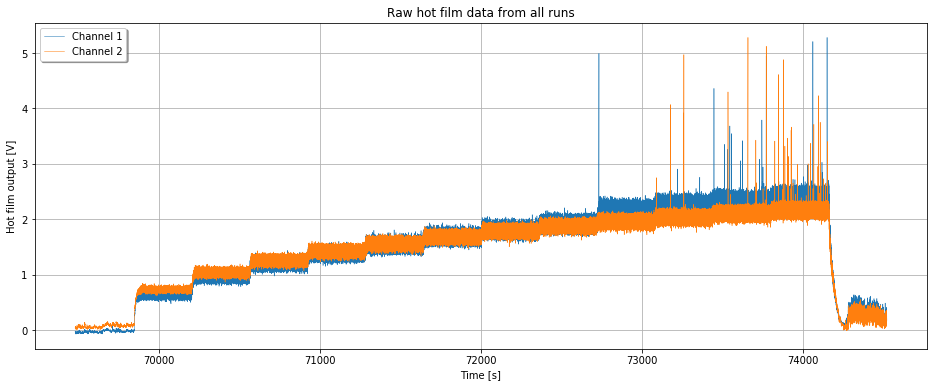

In [3]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
plt.plot(hotfilm_seconds, ch1, lw=0.5, label='Channel 1')
plt.plot(hotfilm_seconds, ch2, lw=0.5, label='Channel 2')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Hot film output [V]')
plt.title('Raw hot film data from all runs')

Not too bad. We start seeing first spikes in Channel 1 data at 45 Hz fan speed. The first spike even causes an offset in the voltage for the rest of the runs. These will need to be cleaned out carefully, but let's not worry about it for now. Let's just see how we can convert these voltage outputs into meaninful $u$ and $w$ velocity.

## Step 2: Subset and bin-average the hotfilm data

In this step we want to loop over pitot data (10 Hz), and bin average hot film data from both channels (1000 Hz). This will need finding the right indices that match the times and averaging over bins of 100 elements.

The data from both pitot and hotfilm span all runs, from 0 to 60 Hz, and then back to 0 Hz spin-down. For the fitting step, we want to avoid the 0 Hz run because hotfilm is known to not do well in very low wind (free convection). We'll also omit the first 60 seconds of the 5 Hz run to avoid spin-up data.

Let's first subset the pitot data by searching for the indices that correspond start and end times of our fitting period:

In [4]:
#TODO clean out hotfilm data

# start and end time of fitting period
t0 = exp.runs[1].start_time + timedelta(seconds=60)
t1 = exp.runs[-2].end_time

# start and end seconds of fitting period
t0_seconds = (t0 - origin).total_seconds()
t1_seconds = (t1 - origin).total_seconds()

# start index of pitot and hotfilm time series
n0 = np.argmin((pitot_seconds - t0_seconds)**2)
n1 = np.argmin((pitot_seconds - t1_seconds)**2)
time = pitot_seconds[n0-1:n1]
pitot = u[n0-1:n1] # should be n0:n1, but here we extend the range to handle dropped records in pressure files

Text(0.5, 1.0, 'Pitot velocity from fan = 5 Hz to 60 Hz')

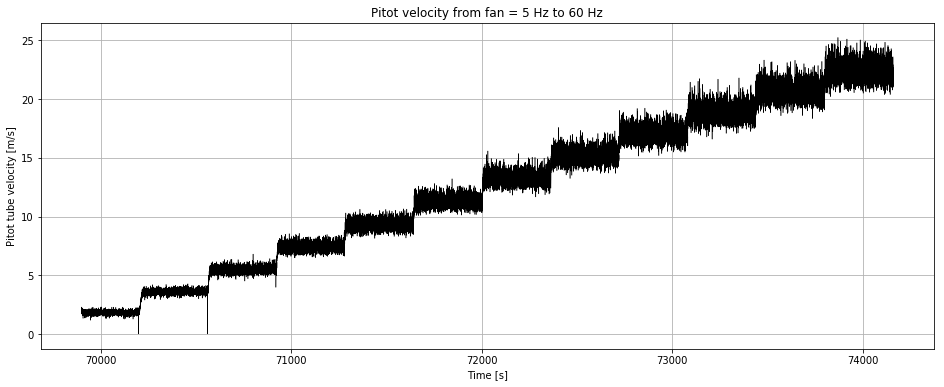

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
plt.plot(time, pitot, 'k-', lw=0.5)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Pitot tube velocity [m/s]')
plt.title('Pitot velocity from fan = 5 Hz to 60 Hz')

This is the data that we'll fit the hotfilm voltages to. Let's define the binning average function so we can calculate hotfilm voltages on the same time axis as pitot. Numpy probably has a built-in but I couldn't find it in short enough time so I wrote a simple one:

In [ ]:
def binavg(x, binsize):
    """Performs a binned average over bins with given binsize."""
    return np.array([np.mean(x[n:n+binsize]) for n in range(0, len(x), binsize)])

OK, now we can look for start and end time indices on the hotfilm time axis (`hotfilm_seconds`), and bin-average over the 100-element bins:

In [ ]:
n0 = np.argmin((hotfilm_seconds - t0_seconds)**2)
n1 = np.argmin((hotfilm_seconds - t1_seconds)**2)
ch1_binavg = binavg(ch1[n0:n1], 100)
ch2_binavg = binavg(ch2[n0:n1], 100)

To confirm that our binned averaging works, our new arrays `ch1_binavg` and `ch2_binavg` should have the same size as the `pitot` array that we will use for fitting, and should look similar to the raw values (see first figure in this notebook):

In [ ]:
print(pitot.size, ch1_binavg.size, ch2_binavg.size)

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
plt.plot(time, ch1_binavg, lw=0.5, label='Channel 1')
plt.plot(time, ch2_binavg, lw=0.5, label='Channel 2')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.xlabel('Time [s]')
plt.ylabel('Hot film output [V]')
plt.title('Hot film data, bin-averaged to 10 Hz')

So far so good! Binned averaging smoothed out the spikes (but introduced a bias to the data, so the spikes must be cleaned out before this process! We'll do this later...). The voltages match the raw data in magnitude, and is on the same time axis as pitot data, exactly what we wanted.

Now it's time to fit the data:

In [ ]:
# 4-th order polynomial -- orderd highest to lowest degree
p1 = np.polyfit(ch1_binavg, pitot, 4)
p2 = np.polyfit(ch2_binavg, pitot, 4)

# compute effective velocities
veff1 = p1[4] + p1[3] * ch1 + p1[2] * ch1**2 + p1[1] * ch1**3 + p1[0] * ch1**4
veff2 = p2[4] + p2[3] * ch2 + p2[2] * ch2**2 + p2[1] * ch2**3 + p2[0] * ch2**4

Now to convert these effective velocities to $u$ and $v$, we'll just follow the IFA manual and use a constant along-wire cooling factor of $k_1 = k_2 = 0.3$, following Mark's MATLAB code.

The function is:

In [ ]:
def hotfilm_velocity(veff1, veff2):
    """For a pair effective velocities from wire 1 and 2,
    calculates u and w components."""
    k1 = k2 = 0.3 # along-wire cooling coefficients for each wire; assume equal
    un = np.sqrt((veff1**2 - k1**2 * veff2**2) / (1 - k1**2 * k2**2)) # normal velocity
    ut = np.sqrt((veff2**2 - k2**2 * veff1**2) / (1 - k1**2 * k2**2)) # tangential velocity
    u = 0.5 * np.sqrt(2.) * (ut + un)
    w = 0.5 * np.sqrt(2.) * (ut - un)
    return u, w

In [ ]:
u, w = hotfilm_velocity(veff1, veff2)

In [ ]:
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(111)
plt.plot(hotfilm_seconds, u, lw=0.5, label=r'$u$')
plt.plot(hotfilm_seconds, w, lw=0.5, label=r'$w$')
plt.legend(loc='upper left', fancybox=True, shadow=True)
plt.grid()
plt.ylim(-10, 40)
plt.xlabel('Time [s]')
plt.ylabel('Hot film velocity [m/s]')
plt.title('Hot film velocities (unclean) @ 1000 Hz')

Outstanding items:

* Despike raw voltages and adjust for offsets;
* Compute the running mean of $u$ and $w$ to see if there's a mean angle in x-y plane;
* Compute fluxes.